# Prédiction des notes par les commentaires

## Import des modules

In [202]:
import numpy as np
import pandas as pd
from pymongo  import MongoClient
import re
import string
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.simplefilter("ignore")

## Connection à la base de données MongoDB

In [2]:

client = MongoClient(host="localhost", port=27017)
db_mongo = client.PLDAC_01
avis = db_mongo.avis

# avis

In [3]:
commentaires,notes = [],[]

for rep in avis.find({}):
  commentaire = rep['comment'] if 'comment' in rep else ""
  # lignes de commentaire vide sont ignorées
  if commentaire == "":
    continue
  
  note = rep['note']
  
  notes.append(note)
  commentaires.append(commentaire)
notes,commentaires = np.array(notes),np.array(commentaires)
print('notes:',len(notes),'commentaire:',len(commentaires))

notes: 186993 commentaire: 186993


## Estimation de densité de la distribution des notes

<Figure size 432x288 with 0 Axes>

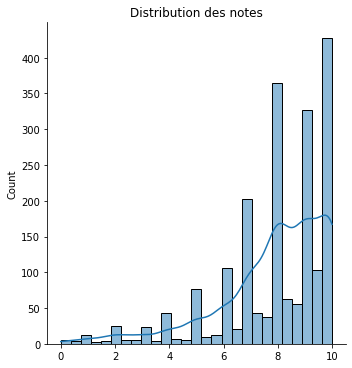

In [4]:
import seaborn as sns

plt.figure()
sns.displot(notes[:2000],kde=True)
plt.title('Distribution des notes')
plt.show()

<Figure size 432x288 with 0 Axes>

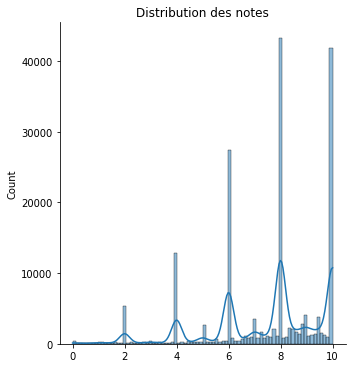

In [5]:
plt.figure()
sns.displot(notes,kde=True)
plt.title('Distribution des notes')
plt.show()

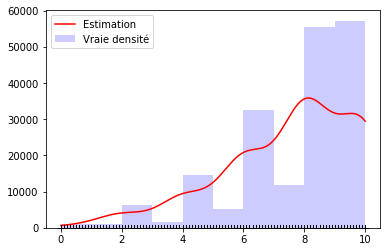

In [199]:
N = 100
X = notes.reshape((notes.size,1))
# préparer les points où on calculera la densité
X_plot = np.linspace(0, 10, 1000)[:, np.newaxis]

# estimation de densité par noyaux gaussiens
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X)
# calcul de la densité pour les données de X_plot
density = np.exp(kde.score_samples(X_plot)) * notes.size

# affichage : vraie densité et estimation
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(X[:,0], bins=10, fc='blue', alpha=0.2, label='Vraie densité')
ax.plot(X_plot[:,0], density, '-', label="Estimation",color='red')
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')
ax.legend(loc='upper left')
plt.show()

## Prétraitement

In [7]:
# fonction qui sup
def supprimer_les_nombres(docs):
    """ Fonction qui supprime tous les nombres dans la chaine de caractères doc

    Args:
        doc (string): chaine de caractère à emputer les nombres

    Returns:
        string: chaine de caractère sans les nombres
    """
    
    return np.array([re.sub('[0-9]+', '', doc) for doc in docs])

def supprimer_la_ponctuation(docs):
    """ Fonction qui supprime tous les nombres dans la chaine de caractères doc

    Args:
        doc (string): chaine de caractère à emputer les nombres

    Returns:
        string: chaine de caractère sans les nombres
    """
    
    punc = string.punctuation 
    punc += '\n\r\t'
    return np.array([doc.translate(str.maketrans(punc, ' ' * len(punc))) for doc in docs])

def pretraitement(docs):
    docs = np.array([doc.lower() for doc in docs])
    docs = supprimer_les_nombres(docs)
    docs = supprimer_la_ponctuation(docs)

    return docs
commentaires = pretraitement(commentaires)

In [8]:
ch = np.array(['SofiA56','23NolwenN','34','SouleymanE62'])
pretraitement(ch)

array(['sofia', 'nolwenn', '', 'souleymane'], dtype='<U10')

In [9]:
print(commentaires[0])

lorsque le jeu est jeu  bon  réflexif  joli pour qui est sensible à ce style d illustration    lorsque l on a envie d y rejouer encore pour essayer autrement  et revivre cette histoire de papillons et de voyages    et lorsqu en plus  au détour des règles  on s intéresse également au propos et à la sensibilisation  légère comme les ailes du dit papillons et pourtant aussi bien amené  alors effectivement  il y a là un très bon jeu  ludiquement parlant  et il est possible de s arrêter là  mais également très bon pour l ouverture des yeux des joueuses et joueurs au monde qui nous entoure    ça  c est deux fois bon  


## Comptages des occurrences des mots et loi Zipf

nombre de mots: 136566


(-2.89, 51.89, 0.0, 1012706.1)

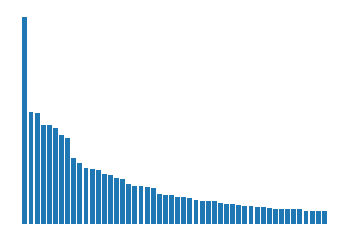

In [10]:
# loi Zipf 

vectorizer = CountVectorizer()
bag_of_words = vectorizer.fit_transform(commentaires)  # creer le bow
sum_words = bag_of_words.sum(axis=0) # nb occurrences de chaque mot
words_freq = [(str(word), sum_words[0, idx]) for word, idx in     vectorizer.vocabulary_.items()] # couple (mot, freq)
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)  # trie par freq decroissante
print('nombre de mots:',len(words_freq))

nmots = 50
x = [w for w,f in words_freq[:nmots]]
y = [f for w,f in words_freq[:nmots]]

plt.figure()
plt.bar(x,y)
plt.axis('off')

### Les k mots les plus fréquents

In [15]:
words_ord = [w for w,f in words_freq]
k = 200
print([w for w in words_ord[:k]])  # les k mots les plus fréquents

['de', 'et', 'le', 'un', 'est', 'les', 'jeu', 'la', 'des', 'en', 'pas', 'pour', 'on', 'une', 'que', 'qui', 'il', 'mais', 'ce', 'du', 'plus', 'je', 'dans', 'ne', 'avec', 'très', 'bien', 'au', 'qu', 'tout', 'se', 'sur', 'ou', 'sont', 'vous', 'cartes', 'peu', 'par', 'même', 'si', 'joueurs', 'partie', 'fait', 'bon', 'peut', 'ai', 'faire', 'parties', 'ça', 'jouer', 'son', 'être', 'jeux', 'règles', 'sans', 'comme', 'trop', 'donc', 'faut', 'vraiment', 'aux', 'autres', 'me', 'petit', 'aussi', 'assez', 'car', 'ses', 'quand', 'nous', 'deux', 'moins', 'simple', 'beaucoup', 'matériel', 'temps', 'cette', 'mon', 'sa', 'fois', 'avoir', 'joueur', 'chaque', 'points', 'thème', 'là', 'où', 'tour', 'entre', 'cela', 'moi', 'encore', 'bonne', 'tous', 'plateau', 'carte', 'autre', 'après', 'alors', 'non', 'toujours', 'plaisir', 'rien', 'quelques', 'vite', 'reste', 'hasard', 'ont', 'suis', 'bref', 'dés', 'joue', 'choix', 'va', 'ces', 'ambiance', 'mal', 'lui', 'ma', 'surtout', 'coup', 'grand', 'soit', 'mécaniqu

### Les k mots les moins fréquents

In [60]:
# les moins fréquents majoritairement des erreurs de frappes et des exagérations
print([w for w in words_ord[-k:]])  # les k mots les moins fréquents

['ansj', 'iocher', 'eculer', 'billepmobs', 'trekeez', 'personnellment', 'télés', 'tournables', 'magner', 'klix', 'fabriquable', 'jactances', 'jacasseries', 'jacasse', 'jaconas', 'jacqueries', 'jacobin', 'lanternent', 'reflexionnite', 'accrocheurson', 'bonzhomme', 'harkonens', 'moissoneuses', 'choississions', 'pochete', 'colectionner', 'surperposent', 'affets', 'estomaquer', 'porpose', 'succéssive', 'oqp', 'confortés', 'mentirait', 'accuserait', 'retrogradage', 'rétrogradage', 'zhuhai', 'sépang', 'vrâie', 'bômbâssâtômik', 'maitrisiez', 'simlpes', 'nretrait', 'mécaniqme', 'troupez', 'minutesmais', 'placeprise', 'joueun', 'simplissimesmes', 'versaillais', 'transfiguration', 'otut', 'digestechez', 'rationps', 'prévisionssans', 'qont', 'banker', 'isoléments', 'recueillit', 'rösner', 'embarassés', 'thésoriser', 'démultiplicateur', 'sonte', 'crours', 'goldenboy', 'uniquementc', 'épargnants', 'stratégiquea', 'choixa', 'retardde', 'prohibe', 'pingle', 'calculatiore', 'sdjsp', 'bridgée', 'pinédo

## Rééquilibrage des classes

In [93]:
notes_en = np.around(notes)
notes_un,nb_notes = np.unique(notes_en,return_counts=True)
print('\n  Somme cumulée croissante:',np.cumsum(nb_notes)/nb_notes.sum())
print('Distribution des notes:',nb_notes)

N_min = np.min(nb_notes)
print('Minimum des notes:',N_min)
commentaires_eq,notes_eq = [],[]
notes_float_eq = []
for cl in notes_un:
  i_cl = notes_en == cl
  commentaires_cl = commentaires[i_cl]
  notes_cl = notes_en[i_cl]
  notes_float_cl = notes[i_cl]
  
  # Un petit shuffle
  i_rand = np.arange(commentaires_cl.shape[0])
  np.random.shuffle(i_rand)
  commentaires_cl = commentaires_cl[i_rand[:N_min]]

  # chaque classe présente N_min lignes
  for i in range(N_min): 
    commentaires_eq.append(commentaires_cl[i])
    notes_eq.append(notes_cl[i])
    notes_float_eq.append(notes_float_cl[i])

commentaires_eq,notes_eq = np.array(commentaires_eq),np.array(notes_eq)
notes_float_eq = np.array(notes_float_eq)
print('Nouvelle taille',len(commentaires_eq),len(notes_eq),N_min*notes_un.shape[0])


  Somme cumulée croissante: [0.00349211 0.00853508 0.04261122 0.04999118 0.12675876 0.14995749
 0.31931677 0.3701315  0.66190713 0.74342355 1.        ]
Distribution des notes: [  653   943  6372  1380 14355  4338 31669  9502 54560 15243 47978]
Minimum des notes: 653
Nouvelle taille 7183 7183 7183


In [96]:
print(len(commentaires_eq),len(notes_eq),N_min*notes_un.shape[0])


7183 7183 7183


### Kde sur les classes rééquilibrées(juste pour voir)

<Figure size 432x288 with 0 Axes>

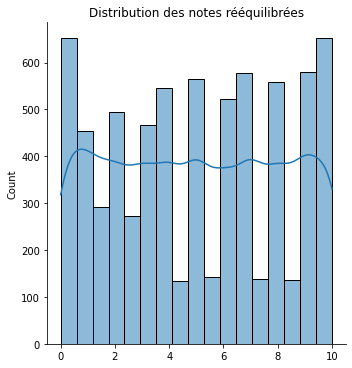

In [65]:
# Avec des notes float
plt.figure()
sns.displot(notes_float_eq,kde=True)
plt.title('Distribution des notes rééquilibrées')
plt.show()

<Figure size 432x288 with 0 Axes>

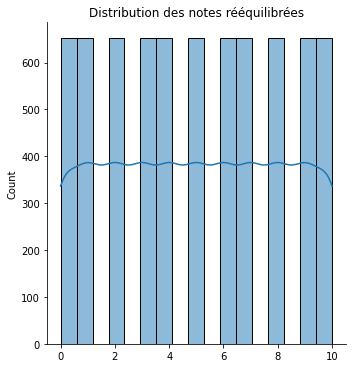

In [66]:
# Avec les notes en entier
plt.figure()
sns.displot(notes_eq,kde=True)
plt.title('Distribution des notes rééquilibrées')
plt.show()

## Mots les plus fréquents après rééquilibre

nombre de mots: 29756


(-2.89, 51.89, 0.0, 37682.4)

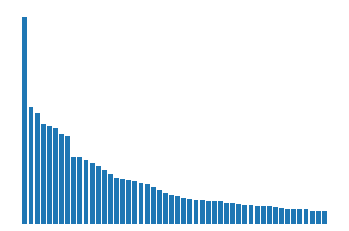

In [196]:
# loi Zipf 

vectorizer = CountVectorizer()
bag_of_words_eq = vectorizer.fit_transform(commentaires_eq)  # creer le bow
sum_words_eq = bag_of_words_eq.sum(axis=0) # nb occurrences de chaque mot
words_freq_eq = [(str(word), sum_words_eq[0, idx]) for word, idx in     vectorizer.vocabulary_.items()] # couple (mot, freq)
words_freq_eq =sorted(words_freq_eq, key = lambda x: x[1], reverse=True)  # trie par freq decroissante
print('nombre de mots:',len(words_freq_eq))

nmots = 50
x = [w for w,f in words_freq_eq[:nmots]]
y = [f for w,f in words_freq_eq[:nmots]]

plt.figure()
plt.bar(x,y)
plt.axis('off')

In [198]:
words_ord_eq = [w for w,f in words_freq_eq]
k = 200
print([w for w in words_ord_eq[:k] if w not in stopwords.words('french')])  # les k mots les plus fréquents

['jeu', 'plus', 'bien', 'très', 'tout', 'cartes', 'si', 'peu', 'fait', 'partie', 'peut', 'ça', 'faire', 'joueurs', 'bon', 'être', 'jouer', 'trop', 'sans', 'jeux', 'parties', 'règles', 'comme', 'vraiment', 'donc', 'autres', 'faut', 'quand', 'car', 'assez', 'moins', 'avoir', 'deux', 'rien', 'là', 'aussi', 'temps', 'tour', 'fois', 'non', 'matériel', 'beaucoup', 'joueur', 'cette', 'carte', 'petit', 'où', 'alors', 'après', 'encore', 'dés', 'points', 'cela', 'thème', 'autre', 'chaque', 'simple', 'entre', 'plateau', 'vite', 'tous', 'bref', 'bonne', 'hasard', 'mal', 'joue', 'reste', 'quelques', 'mécanique', 'chose', 'intérêt', 'va', 'toujours', 'grand', 'trouve', 'coup', 'choix', 'fin', 'plaisir', 'dire', 'plutôt', 'sympa', 'avis', 'ambiance', 'surtout', 'chance', 'mieux', 'déjà', 'stratégie', 'point', 'autant', 'oui', 'enfants', 'extension', 'part', 'plusieurs', 'place', 'avant', 'joué', 'fun', 'boîte', 'base', 'monde', 'qualité', 'aime', 'seul', 'voir', 'contre', 'gros', 'actions', 'côté', '

## Word cloud

### Word cloud de tous les commentaires(classes confondues)

(-0.5, 399.5, 199.5, -0.5)

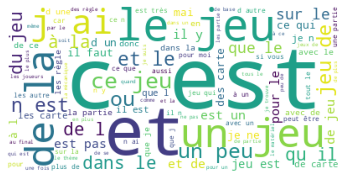

In [13]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS # Note: this is the default option    

corpus = list(commentaires_eq)
corpus = " ".join(corpus)
# print(corpus[:50])
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=100).generate(corpus) 

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

### Word cloud pour chaque classe

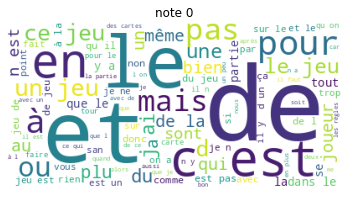

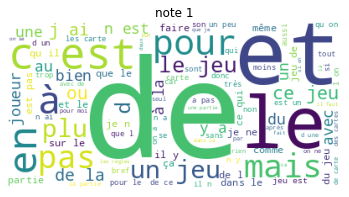

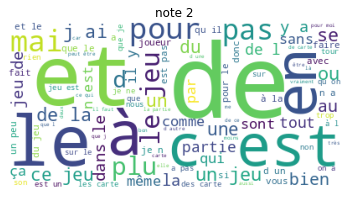

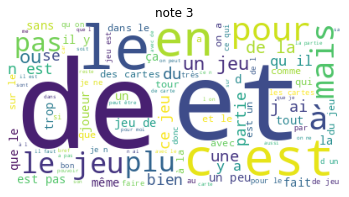

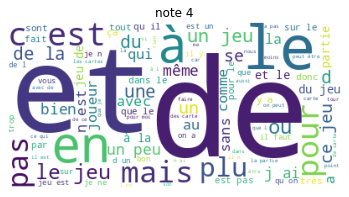

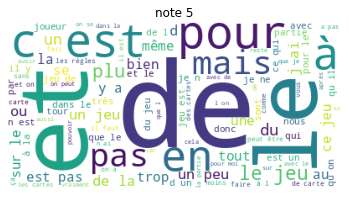

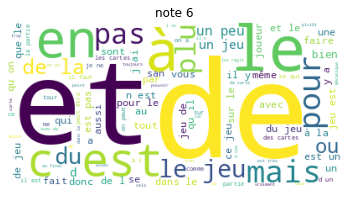

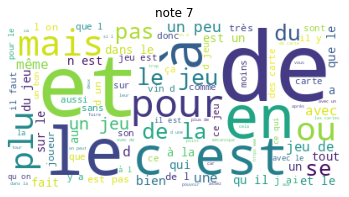

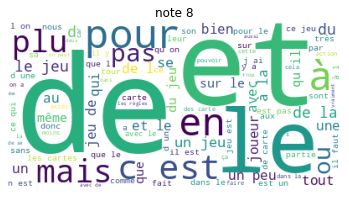

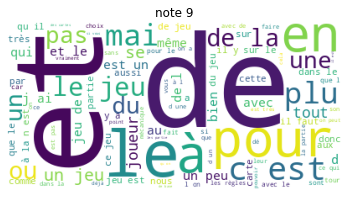

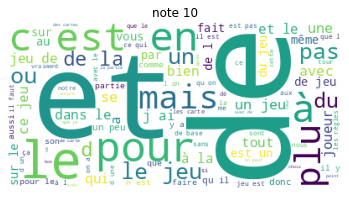

In [16]:
k = 0 # les k motes les plus fréquents à ne pas considérer
for i in range(notes_un.shape[0]):
  
  # commentaires de chaque note
  i_commentaire_note = notes_eq == notes_un[i]
  commentaire_note = commentaires_eq[i_commentaire_note]
  
  # les mots les plus fréquent de chaque note
  corpus_note = " ".join(list(commentaire_note))
  wordcloud = WordCloud(background_color='white', stopwords = [w for w in words_ord[:k]], max_words=100).generate(corpus_note)

  plt.figure()
  plt.imshow(wordcloud)
  plt.title('note '+str(i))
  plt.axis('off')

### Word cloud de chaque classe sans les k mots les plus fréquents

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/souleymbaye/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


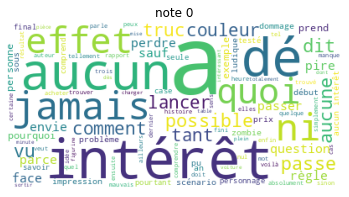

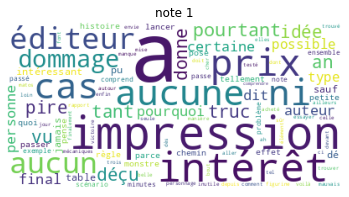

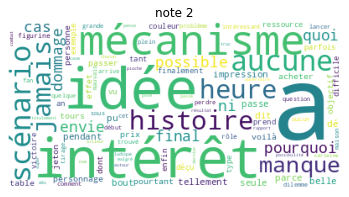

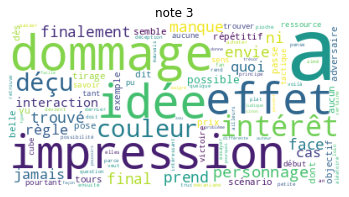

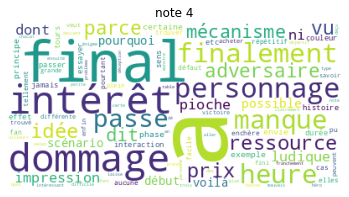

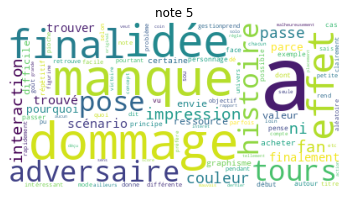

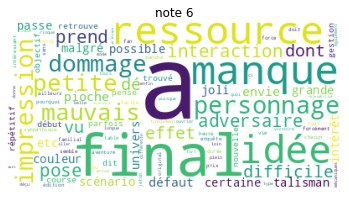

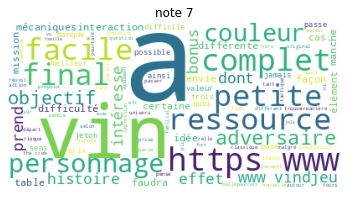

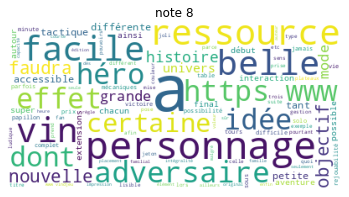

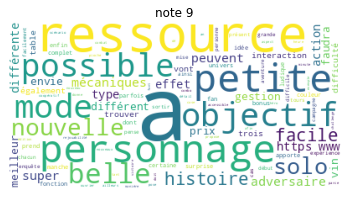

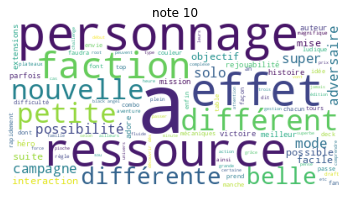

In [68]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

k = 200 # les k motes les plus fréquents à ne pas considérer
stopwords_list = stopwords.words('french') + [w for w in words_ord[:k]]

for i in range(notes_un.shape[0]):
  
  # commentaires de chaque note
  i_commentaire_note = notes_eq == notes_un[i]
  commentaire_note = commentaires_eq[i_commentaire_note]
  
  # les mots les plus fréquent de chaque note
  corpus_note = " ".join(list(commentaire_note))
  wordcloud = WordCloud(background_color='white', stopwords = stopwords_list, max_words=100).generate(corpus_note)

  plt.figure()
  plt.imshow(wordcloud)
  plt.title('note '+str(i))
  plt.axis('off')

### Word cloud en biclasse sans les k mots les plus fréquents

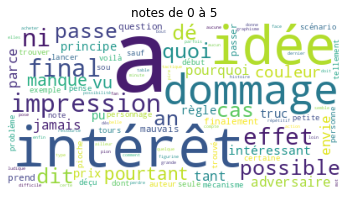

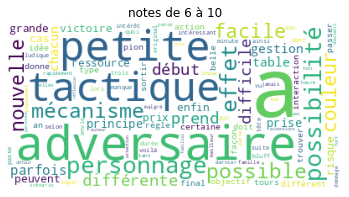

In [200]:
k = 200 # les k motes les plus fréquents à ne pas considérer
stopwords_list = stopwords.words('french') + [w for w in words_ord[:k]]

# commentaires des notes négatives
i_commentaire_note = notes_eq <= 5
commentaire_note = commentaires_eq[i_commentaire_note]

# les mots les plus fréquent de chaque note
corpus_note = " ".join(list(commentaire_note))
wordcloud = WordCloud(background_color='white', stopwords = stopwords_list, max_words=100).generate(corpus_note)

plt.figure()
plt.imshow(wordcloud)
plt.title('notes de 0 à 5')
plt.axis('off')
plt.show()

# commentaires des notes positives
i_commentaire_note = notes_eq > 5
commentaire_note = commentaires_eq[i_commentaire_note]

# les mots les plus fréquent de chaque note
corpus_note = " ".join(list(commentaire_note))
wordcloud = WordCloud(background_color='white', stopwords = stopwords_list, max_words=100).generate(corpus_note)

plt.figure()
plt.imshow(wordcloud)
plt.title('notes de 6 à 10')
plt.axis('off')
plt.show()

On voit des mots négatifs sur les petites notes (jamais,dommage,manque,ni,envie,pourtant,déçu,passe) et positifs(belle,possible,nouvelle,interaction,ressource,facile,objectif) dans les notes hautes.

## Prédiction des notes à partir des commentaires

In [19]:
# séparation train test
from sklearn.model_selection import train_test_split

X,y = commentaires_eq,notes_eq
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0) 

tt = len(y_train)+len(y_test)
print(len(y_train)/tt,len(y_test)/tt)

0.7999443129611583 0.20005568703884172


In [245]:
# Obtenir les caractéristiques les plus importantes pour un modèle
def mots_importants(model,n=10):
  feature_weights = model.coef_[0]
  top_features = {
      'positive': [vectorizer.get_feature_names_out()[i] for i in feature_weights.argsort()[-n:][::-1]],
      'negative': [vectorizer.get_feature_names_out()[i] for i in feature_weights.argsort()[:n]]
  }

  
  return top_features['positive'],top_features['negative']

In [246]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

classes = y_train
corpus = X_train
classes_test = y_test
corpus_test = X_test

def prediction(vect=CountVectorizer,**args):
  
  vectorizer = vect(**args)

  X = vectorizer.fit_transform(corpus)
  # print(vectorizer.get_feature_names()[:10]) # we only print a few
  print(X.shape)

  #Naïve Bayes
  nb_clf = MultinomialNB()
  nb_clf.fit(X, classes)


  #Logistic Regression
  lr_clf = LogisticRegression(random_state=0, solver='lbfgs',max_iter=1000,n_jobs=-1)
  lr_clf.fit(X, classes)

  #Linear SVM
  svm_clf = LinearSVC(random_state=0, tol=1e-5)
  svm_clf.fit(X, classes)


  X_t = vectorizer.transform(corpus_test)

  pred_nb = nb_clf.predict(X_t)
  pred_lr = lr_clf.predict(X_t)
  pred_svm = svm_clf.predict(X_t)


  print(f"Naïve Bayes accuracy: {accuracy_score(classes_test, pred_nb)}")
  print(f"Logistic Regression accuracy: {accuracy_score(classes_test, pred_lr)}")
  print(f"SVM accuracy: {accuracy_score(classes_test, pred_svm)}")

  return nb_clf,lr_clf,svm_clf

### Avec tous les mots du corpus

In [204]:
classes = y_train
corpus = X_train
classes_test = y_test
corpus_test = X_test
r = prediction(CountVectorizer)

(5746, 25709)
Naïve Bayes accuracy: 0.45998608211551845
Logistic Regression accuracy: 0.5073068893528184
SVM accuracy: 0.4968684759916493


Nous avons des performances meilleurs que celles de la fois fois.

### Sans les k=200 mots les plus fréquents

In [203]:
classes = y_train
corpus = X_train
classes_test = y_test
corpus_test = X_test
k = 200
r = prediction(CountVectorizer,stop_words=[w for w in words_ord[:k]])

(5746, 25509)
Naïve Bayes accuracy: 0.47738343771746694
Logistic Regression accuracy: 0.5198329853862212
SVM accuracy: 0.5038274182324287


### Sans les k=200 mots les plus fréquents et les 200 moins fréquents

In [205]:
# apprentissage en supprimant les k mots les plus fréquents
classes = y_train
corpus = X_train
classes_test = y_test
corpus_test = X_test

k = 200
r = prediction(CountVectorizer,stop_words=[w for w in words_ord[:k]] + [w for w in words_ord[-k:]])

(5746, 25508)
Naïve Bayes accuracy: 0.47738343771746694
Logistic Regression accuracy: 0.5198329853862212
SVM accuracy: 0.5038274182324287


### Sans les k=1_000 mots les plus fréquents

In [206]:
# apprentissage en supprimant les k mots les plus fréquents
classes = y_train
corpus = X_train
classes_test = y_test
corpus_test = X_test

k = 1_000
stopwords_list = stopwords.words('french') + [w for w in words_ord[:k]] # + [w for w in words_ord[-k:]]
r = prediction(CountVectorizer,stop_words=stopwords_list)

(5746, 24672)
Naïve Bayes accuracy: 0.45650661099512874
Logistic Regression accuracy: 0.5093945720250522
SVM accuracy: 0.4899095337508699


### Sans les mots les plus fréquents du français

In [207]:
# apprentissage en supprimant les k mots les plus fréquents
classes = y_train
corpus = X_train
classes_test = y_test
corpus_test = X_test

k = 2_000
stopwords_list = stopwords.words('french') #+ [w for w in words_ord[:k]] # + [w for w in words_ord[-k:]]
r = prediction(CountVectorizer,stop_words=stopwords_list)



(5746, 25590)
Naïve Bayes accuracy: 0.46346555323590816
Logistic Regression accuracy: 0.5142658315935977
SVM accuracy: 0.5024356297842728


### Sans les k=2_000 mots les plus fréquents

In [208]:
# apprentissage en supprimant les k mots les plus fréquents
classes = y_train
corpus = X_train
classes_test = y_test
corpus_test = X_test

k = 2_000
stopwords_list = [w for w in words_ord[:k]] # + [w for w in words_ord[-k:]]
r = prediction(CountVectorizer,stop_words=stopwords_list)

(5746, 23709)
Naïve Bayes accuracy: 0.4523312456506611
Logistic Regression accuracy: 0.4822546972860125
SVM accuracy: 0.4780793319415449


### avec des bigrammes

In [209]:
# apprentissage en supprimant les k mots les plus fréquents
classes = y_train
corpus = X_train
classes_test = y_test
corpus_test = X_test

k = 200
# stopwords_list = stopwords.words('french') #+ [w for w in words_ord[:k]] # + [w for w in words_ord[-k:]]
stopwords_list = [w for w in words_ord[:k]] # + [w for w in words_ord[-k:]]

r = prediction(CountVectorizer,stop_words=stopwords_list,ngram_range=(1,2))


(5746, 224002)
Naïve Bayes accuracy: 0.524008350730689
Logistic Regression accuracy: 0.5288796102992345
SVM accuracy: 0.510786360473208


### Avec des trigrammes

In [218]:
# apprentissage en supprimant les k mots les plus fréquents
classes = y_train
corpus = X_train
classes_test = y_test
corpus_test = X_test

k = 200
# stopwords_list = stopwords.words('french') #+ [w for w in words_ord[:k]] # + [w for w in words_ord[-k:]]
stopwords_list = [w for w in words_ord[:k]] # + [w for w in words_ord[-k:]]

r = prediction(CountVectorizer,stop_words=stopwords_list,ngram_range=(1,3))


(5746, 441059)
Naïve Bayes accuracy: 0.5219206680584552
Logistic Regression accuracy: 0.523312456506611
SVM accuracy: 0.5149617258176757


### bigrammes et trigrammes

In [233]:
# apprentissage en supprimant les k mots les plus fréquents
classes = y_train
corpus = X_train
classes_test = y_test
corpus_test = X_test

k = 200
# stopwords_list = stopwords.words('french') #+ [w for w in words_ord[:k]] # + [w for w in words_ord[-k:]]
stopwords_list = [w for w in words_ord[:k]] # + [w for w in words_ord[-k:]]

r = prediction(CountVectorizer,stop_words=stopwords_list,ngram_range=(2,3))


(5746, 415550)
Naïve Bayes accuracy: 0.47947112038970074
Logistic Regression accuracy: 0.464857341684064
SVM accuracy: 0.4558107167710508


# Prédiction avec séparation des notes en deux classes

In [247]:
# apprentissage en supprimant les k mots les plus fréquents
# classification binaire decoupage (0 à 5 -> -1) (6 à 10 -> 1)
classes = [1 if note>5 else -1 for note in y_train]
corpus = X_train
classes_test = [1 if note>5 else -1 for note in y_test]
corpus_test = X_test

k = 200
stopwords_list = stopwords.words('french') #+ [w for w in words_ord[:k]] # + [w for w in words_ord[-k:]]

nb_clf,lr_clf,svm_clf = prediction(CountVectorizer,stop_words=stopwords_list)

(5746, 25590)
Naïve Bayes accuracy: 0.8649965205288797
Logistic Regression accuracy: 0.8893528183716075
SVM accuracy: 0.860125260960334


### Les mots les plus importants

In [248]:
mots_pos,mots_neg = mots_importants(lr_clf)
print('Mots positifs :',mots_pos)
print('Mots negatifs :',mots_neg)

Mots positifs : ['désagréable', 'foiré', 'after', 'adequat', 'parterres', 'lutté', 'kahuna', 'sacré', 'money', 'illuminati']
Mots negatifs : ['demanderait', 'grimer', 'assume', 'dédiées', 'ends', 'cthulhuien', 'enfin', 'accomplis', 'raccroche', 'icône']


In [249]:
mots_pos,mots_neg = mots_importants(svm_clf)
print('Mots positifs :',mots_pos)
print('Mots negatifs :',mots_neg)

Mots positifs : ['conspuer', 'kahuna', 'gagnerions', 'fendre', 'désagréable', 'sort', 'parterres', 'bière', 'cordes', 'introduire']
Mots negatifs : ['demanderait', 'initialement', 'péons', 'repères', 'démolition', 'boudin', 'accompagner', 'hic', 'raccroche', 'hélas']


### Prédiction avec séparation des notes en deux classes sans les k=200 moins fréquents

In [163]:
# apprentissage en supprimant les k mots les plus fréquents
# classification binaire decoupage (0 à 5 -> -1) (6 à 10 -> 1)
classes = [1 if note>5 else -1 for note in y_train]
corpus = X_train
classes_test = [1 if note>5 else -1 for note in y_test]
corpus_test = X_test

k = 200
stop_words = stopwords.words('french') + [w for w in words_ord[:k]] + [w for w in words_ord[-2*k:]]

nb_clf,lr_clf,svm_clf = prediction(CountVectorizer,stop_words=stopwords_list)


(5746, 25509)
Naïve Bayes accuracy: 0.8587334725121781
Logistic Regression accuracy: 0.8796102992345164
SVM accuracy: 0.8510786360473208


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Prédiction avec séparation des notes en deux classes sans les k=2_000 moins fréquents

In [215]:
# apprentissage en supprimant les k mots les plus fréquents
# classification binaire decoupage (0 à 5 -> -1) (6 à 10 -> 1)
classes = [1 if note>5 else -1 for note in y_train]
corpus = X_train
classes_test = [1 if note>5 else -1 for note in y_test]
corpus_test = X_test

k = 2000
stop_words = stopwords.words('french') + [w for w in words_ord[:k]] + [w for w in words_ord[-k:]]

nb_clf,lr_clf,svm_clf = prediction(CountVectorizer,stop_words=stopwords_list)


(5746, 3655)
Naïve Bayes accuracy: 0.6026443980514962
Logistic Regression accuracy: 0.6026443980514962
SVM accuracy: 0.6026443980514962


### En enlevant les 20_000 termes les fréquents

In [216]:
# apprentissage en supprimant les k mots les plus fréquents
# classification binaire decoupage (0 à 5 -> -1) (6 à 10 -> 1)
classes = [1 if note>5 else -1 for note in y_train]
corpus = X_train
classes_test = [1 if note>5 else -1 for note in y_test]
corpus_test = X_test

k = 20_000
stop_words = stopwords.words('french') + [w for w in words_ord[:k]] + [w for w in words_ord[-k:]]

nb_clf,lr_clf,svm_clf = prediction(CountVectorizer,stop_words=stopwords_list)


(5746, 3655)
Naïve Bayes accuracy: 0.6026443980514962
Logistic Regression accuracy: 0.6026443980514962
SVM accuracy: 0.6026443980514962


# Avec du steming

In [172]:
from nltk.stem.snowball import FrenchStemmer

def stem(docs):
  docs_stem = []
  stemmer = FrenchStemmer()
  
  for i in range(docs.shape[0]):
    tokens = str(docs[i]).split()

    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    stemmed_text = " ".join(stemmed_tokens)
    docs_stem.append(stemmed_text)
  
  return np.array(docs_stem)

commentaires_stem = stem(commentaires)
corpus_stem = stem(X_train)
corpus_test_stem = stem(X_test)

In [176]:
print(commentaires[0],'\n  -->\n',commentaires_stem[0])

lorsque le jeu est jeu  bon  réflexif  joli pour qui est sensible à ce style d illustration    lorsque l on a envie d y rejouer encore pour essayer autrement  et revivre cette histoire de papillons et de voyages    et lorsqu en plus  au détour des règles  on s intéresse également au propos et à la sensibilisation  légère comme les ailes du dit papillons et pourtant aussi bien amené  alors effectivement  il y a là un très bon jeu  ludiquement parlant  et il est possible de s arrêter là  mais également très bon pour l ouverture des yeux des joueuses et joueurs au monde qui nous entoure    ça  c est deux fois bon   
  -->
 lorsqu le jeu est jeu bon réflex jol pour qui est sensibl à ce styl d illustr lorsqu l on a envi d y rejou encor pour essai autr et revivr cet histoir de papillon et de voyag et lorsqu en plus au détour de regl on s intéress égal au propos et à la sensibilis léger comm le ail du dit papillon et pourt auss bien amen alor effect il y a là un tres bon jeu ludiqu parl et il

In [ ]:
print(X_train[0],'\n  -->\n',corpus_stem[0])

bon la charte graphique je ne suis pas emporté par les qualités des illustrations même si ça reste chouette  ensuite la mécanique entièrement liée au hasard il s agit de faire des majorités pour appliquer le pouvoir du personnage sachant qu elles ne sont pas présentent en même nombre  le  y est  fois  le  y est  fois      pas convaincu car on va s acharner toujours sur ceux qui mènent pour pourrir leur tour et surtout on ne peut absolument pas élaborer de stratégie  on conserve quelques cartes  de plus en plus  sur son board en fin de manche et on en a de moins en moins au début de chaque manche mais on est limité au nombre de cartes à poser  imaginons qu on veut faire un coup en conservant des  pour essayer d y être majoritaire le tour suivant  si aucun  ne nous est distribué on a gardé ces  virtuellement pour rien  il existe de meilleurs jeux dans cette mécanique pour moi 
  -->
 bon la chart graphiqu je ne suis pas emport par le qualit de illustr mêm si ça rest chouet ensuit la méca

## Comptages des occurrences des mots et loi Zipf

nombre de mots: 83566


(-2.89, 51.89, 0.0, 1336384.35)

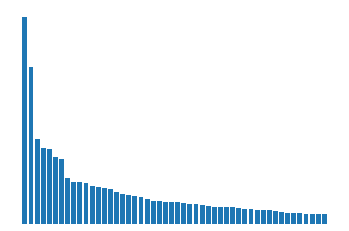

In [177]:
# loi Zipf 

vectorizer = CountVectorizer()
bag_of_words_stem = vectorizer.fit_transform(commentaires_stem)  # creer le bow
sum_words_stem = bag_of_words_stem.sum(axis=0) # nb occurrences de chaque mot
words_freq_stem = [(str(word), sum_words_stem[0, idx]) for word, idx in     vectorizer.vocabulary_.items()] # couple (mot, freq)
words_freq_stem =sorted(words_freq_stem, key = lambda x: x[1], reverse=True)  # trie par freq decroissante
print('nombre de mots:',len(words_freq_stem))

nmots = 50
x = [w for w,f in words_freq_stem[:nmots]]
y = [f for w,f in words_freq_stem[:nmots]]

plt.figure()
plt.bar(x,y)
plt.axis('off')

In [178]:
words_ord_stem = [w for w,f in words_freq_stem]
k = 200
print([w for w in words_ord_stem[:k]])  # les k mots les plus fréquents

['de', 'le', 'et', 'un', 'est', 'jeu', 'la', 'en', 'pas', 'pour', 'on', 'une', 'que', 'il', 'qui', 'ce', 'mais', 'du', 'plus', 'je', 'part', 'se', 'dan', 'ne', 'avec', 'tout', 'tres', 'bien', 'au', 'cart', 'qu', 'bon', 'sur', 'jou', 'joueur', 'ou', 'sont', 'vous', 'mêm', 'par', 'peu', 'si', 'fait', 'ai', 'peut', 'autr', 'regl', 'fair', 'vrai', 'ça', 'son', 'être', 'simpl', 'me', 'jeux', 'san', 'comm', 'point', 'trop', 'faut', 'donc', 'aux', 'tour', 'mécan', 'cet', 'grand', 'pet', 'trouv', 'auss', 'assez', 'car', 'quand', 'cel', 'nous', 'deux', 'moin', 'rapid', 'premi', 'matériel', 'beaucoup', 'temp', 'strateg', 'mon', 'plac', 'sa', 'aim', 'them', 'certain', 'fois', 'quelqu', 'avoir', 'seul', 'petit', 'fin', 'chaqu', 'pass', 'plateau', 'plais', 'dé', 'coup', 'là', 'où', 'entre', 'rest', 'moi', 'encor', 'tous', 'action', 'extens', 'différent', 'apres', 'alor', 'sort', 'gagn', 'non', 'hasard', 'toujour', 'leur', 'vit', 'aur', 'rien', 'don', 'bas', 'ont', 'bref', 'suis', 'elle', 'choix', '

## Prédiction en biclasses

In [217]:
# apprentissage en supprimant les k mots les plus fréquents
classes = [1 if note>5 else -1 for note in y_train]
corpus = corpus_stem
classes_test = [1 if note>5 else -1 for note in y_test]
corpus_test = corpus_test_stem

k = 200
stopwords_list = stopwords.words('french') #+ [w for w in words_ord[:k]] # + [w for w in words_ord[-k:]]

nb_clf,lr_clf,svm_clf = prediction(CountVectorizer,stop_words=stopwords_list)


(5746, 14290)
Naïve Bayes accuracy: 0.8608211551844119
Logistic Regression accuracy: 0.8733472512178149
SVM accuracy: 0.860125260960334


## steming sans les k mots les plus fréquents

In [182]:
k = 200
stopwords_list =  [w for w in words_ord_stem[:k]] # + [w for w in words_ord[-k:]]

nb_clf,lr_clf,svm_clf = prediction(CountVectorizer,stop_words=stopwords_list)


(5746, 14171)


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Naïve Bayes accuracy: 0.848295059151009
Logistic Regression accuracy: 0.8496868475991649
SVM accuracy: 0.8475991649269311


## steming plus bigramme

In [183]:
k = 200
stopwords_list =  [w for w in words_ord_stem[:k]] # + [w for w in words_ord[-k:]]

nb_clf,lr_clf,svm_clf = prediction(CountVectorizer,stop_words=stopwords_list,ngram_range=(1,2))


(5746, 184924)


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Naïve Bayes accuracy: 0.883785664578984
Logistic Regression accuracy: 0.8643006263048016
SVM accuracy: 0.8510786360473208


## steming plus trigramme

In [184]:
k = 200
stopwords_list =  [w for w in words_ord_stem[:k]] # + [w for w in words_ord[-k:]]

nb_clf,lr_clf,svm_clf = prediction(CountVectorizer,stop_words=stopwords_list,ngram_range=(1,3))


(5746, 377326)


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Naïve Bayes accuracy: 0.8858733472512178
Logistic Regression accuracy: 0.8636047320807237
SVM accuracy: 0.8496868475991649


In [187]:
k = 200
stopwords_list =  [w for w in words_ord_stem[:k]] # + [w for w in words_ord[-k:]]

nb_clf,lr_clf,svm_clf = prediction(CountVectorizer,stop_words=stopwords_list,ngram_range=(2,2))


(5746, 170753)
Naïve Bayes accuracy: 0.8308977035490606
Logistic Regression accuracy: 0.8058455114822547
SVM accuracy: 0.8037578288100209


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [188]:
k = 200
stopwords_list =  [w for w in words_ord_stem[:k]] # + [w for w in words_ord[-k:]]

nb_clf,lr_clf,svm_clf = prediction(CountVectorizer,stop_words=stopwords_list,ngram_range=(2,3))


(5746, 363155)


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Naïve Bayes accuracy: 0.8239387613082811
Logistic Regression accuracy: 0.7947112038970077
SVM accuracy: 0.7870563674321504


## TfIdf

In [193]:
from sklearn.feature_extraction.text import TfidfVectorizer

use_idf=True
smooth_idf=True
sublinear_tf=False


In [195]:
# apprentissage en supprimant les k mots les plus fréquents
# classification binaire decoupage (0 à 5 -> -1) (6 à 10 -> 1)
classes = [1 if note>5 else -1 for note in y_train]
corpus = X_train
classes_test = [1 if note>5 else -1 for note in y_test]
corpus_test = X_test

k = 200
stopwords_list =  [w for w in words_ord_stem[:k]]

nb_clf,lr_clf,svm_clf = prediction(TfidfVectorizer,stop_words=stopwords_list,use_idf= use_idf, smooth_idf=smooth_idf, sublinear_tf=sublinear_tf)

(5746, 25566)
Naïve Bayes accuracy: 0.8538622129436325
Logistic Regression accuracy: 0.8677800974251914
SVM accuracy: 0.8823938761308281


### Prédiction des notes avec la régression linéaire (pas satisfaisant)

In [54]:
# apprentissage en supprimant les k mots les plus fréquents

classes = y_train
corpus = X_train

k = 2000
vectorizer = CountVectorizer(stop_words=[w for w in words_ord[:k]])

X = vectorizer.fit_transform(corpus)
# print(vectorizer.get_feature_names()[:10]) # we only print a few
X = X.toarray().astype(float)
X_t = vectorizer.transform(X_test)
X_t = X_t.toarray().astype(float)
print(X.shape)

(5746, 23709)


#### Normalisation sur les colonnes

In [55]:
def normalise(X,max_cols=[],min_cols=[]):
  if len(max_cols) == 0:
    max_cols = X.max(axis=0)  # max de chaque colonne
  if len(min_cols) == 0:
    min_cols = X.min(axis=0)  # min de chaque colonne

  for j in range(X.shape[1]):
    max_c,min_c = max_cols[j], min_cols[j]
    d = max_c - min_c
    for i in range(X.shape[0]):
      if d == 0:
        X[i,j] = 0  # pour eviter NaN
      else:
        X[i,j] = (X[i,j] - min_c) / d

  return X,max_cols,min_cols

In [57]:
from sklearn.linear_model import LinearRegression

X_n,max_cols,min_cols = normalise(X)
lr = LinearRegression()
lr.fit(X_n, classes)

X_t_n,max_cols,min_cols = normalise(X_t,max_cols,min_cols)

pred_lr = lr.predict(X_t_n)

err = np.abs(y_test-pred_lr)
err = err.sum() / err.shape[0]

print(f"Linear Regression score: {err}")

Linear Regression score: 11088041016090.23


## Clustering avec KMeans

In [ ]:
# on supprime les colonnes des mots frequents
k = 200
words_un = [w for w,f in words_freq[:k]]
nom_cols = [word for word, idx in vectorizer.vocabulary_.items() if word not in words_un]
i_cols = [idx for word, idx in vectorizer.vocabulary_.items() if word not in words_un]
bow = bag_of_words[:,i_cols]

print(len(nom_cols),len(i_cols),'\n',bag_of_words.shape,bow.shape)

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 11
kmeans = KMeans(n_clusters=n_clusters, random_state=0, max_iter=100).fit(bow)
y_pred = kmeans.predict(bow)

In [ ]:
# Getting clusters:
l_cl_major = []
for c in range(n_clusters):
  i_cl = y_pred == c
  cls,nb_cls = np.unique(notes[i_cl],return_counts=True)
  i_cls_trie = np.argsort(nb_cls)
  c_major = cls[i_cls_trie[0]]
  l_cl_major.append(c_major)
  sum_words = bow[i_cl].sum(axis=0).tolist()[0]
  print('cluster:',c,'classe maj:',c_major,sum_words[:3])
  
  # recopie chaque mot le nombre de fois qu'il est présent dans le cluster
  corpus_cl = []
  for i in range(len(nom_cols)):
    corpus_cl += [nom_cols[i]] * sum_words[i]
  corpus_cl = " ".join(corpus_cl)
  wordcloud = WordCloud(background_color='white', stopwords = [], max_words=100).generate(corpus_cl)

  plt.figure()
  plt.imshow(wordcloud)
  plt.title(i_cls_trie[0])
  plt.axis('off')

## Visualisation en 2D

In [ ]:
# visualisation en 2d mais il ne passe, trop de temps puis il crache
k = 200
vectorizer = CountVectorizer(lowercase=True,stop_words=[w for w in words_ord[:k]])

corpus = list(commentaires_eq)
corpus = " ".join(corpus)
# print(corpus[:5],commentaires_eq[0])
Xu = vectorizer.fit_transform(commentaires_eq)
print(Xu.shape)

(7183, 28125)


In [ ]:
Xu = Xu.toarray()
# U,S,V = np.linalg.svd(Xu.toarray(), full_matrices=False)
lam, V = np.linalg.eig(Xu.T@Xu)

# tri et sélection des 2 vecteurs associés aux 2 plus grandes valeurs propres 
lam_tries_arg = np.argsort(lam)
lam_2_max = np.sort(lam_tries_arg[-2:])
vp = (V[:,lam_2_max])
Xu2D = Xu @ vp

In [ ]:
# affichage (plot) avec un code couleur pour les classes
plt.figure()
for c in range(0,10+1):
  Xc = Xu2D[notes==c]
  plt.scatter(Xc[:,0],Xc[:,1])

plt.legend(np.arange(10+1))